# Image Classification using DenseNet201

This Code Template is for simple image classification using DenseNet 201.

<img src="https://cdn.blobcity.com/assets/gpu_required.png"  height="25" style="margin-bottom:-15px" />

### Required Packages

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
import itertools
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

# TensorFlow Modules
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import DenseNet201
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D
from keras.layers import Input, Add, Dense,GlobalAvgPool2D, Concatenate, AvgPool2D, Dropout, ReLU, Activation, MaxPool2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential
# Visualizations
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

### Initialization
Path of the main folder containing train and test folders
An example for providing a sample path for the base directory :<br>
base_dir = os.path.dirname("/content/dog-cat-full-dataset/data/") <br>
You can clone your data set from github if available or mount the google drive in your colab notebook 


In [3]:
base_dir = os.path.dirname('')

Path of the train and test folders containing image files

In [4]:
train_dir = os.path.join(base_dir, 'train') #train
test_dir = os.path.join(base_dir, 'test') #test

List of target categories which are required for model training and predictions.

In [5]:
target = []

### Data Fetching

The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.

OpenCV-Python is a library of Python bindings designed to solve computer vision problems.

We will use the <Code>os.path</Code> module to interact with the file system and the <Code>cv2.imread()</Code> method to load an image from the specified file path.

### Directory Structure
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Master Directory</b>
 |__<b>train</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
 |__<b>test</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
</pre>

In [6]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

In [7]:
# Loading the image dataset and plotting some images from all target categories
def plot_image(data, target):
  count = 0
  for category in target:
      path=os.path.join(data, category)
      flg = 0
      ar = []
      # storing image paths in an array
      for img in os.listdir(path):
          ar.append(os.path.join(path,img)) 
          flg+= 1
          if flg==2:
            break
      # plotting the images in dataset
      plt.figure(figsize=(5,5))
      for i in range(2):
        d1 = ar[i]
        img_array = cv2.imread(d1,cv2.IMREAD_COLOR)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1,2,i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis("off")
      count+= 1
      if count == len(target):
        break

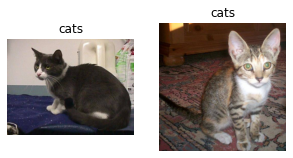

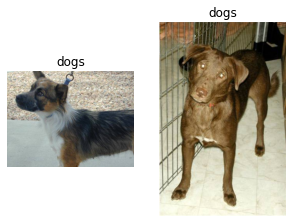

In [8]:
plot_image(train_dir,target)

In [9]:
for file in os.listdir(train_dir):
    print(file)

dogs
cats


### Data Preprocessing

An Image occupies a significant portion of space. Since images represent huge datasets, loading them at once to memory (RAM) can lead to severe scalibility issues and memory limitations. Therefore, in practice, images are loaded directly from the directory structure.   

TensorFlow 2 comes with a handy class called <Code>ImageDataGenerator</Code> that augments images. It takes the following parameters:


1. **rotation_range**:	Int. 
>Degree range for random rotations.

2. **width_shift_range**: Float, 1-D array-like or int
          * float: fraction of total width, if < 1, or pixels if >= 1.
          * 1-D array-like: random elements from the array.
          * int: integer number of pixels from interval (-width_shift_range, +width_shift_range)
          * With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

3. **height_shift_range**:	Float, 1-D array-like or int. 
>Values have similar meaning as width_shift_range

4. **zoom_range**:	Float or [lower, upper]. 
>Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
channel_shift_range	Float. Range for random channel shifts.

5. **horizontal_flip**:	Boolean. 
>Randomly flip inputs horizontally.


6. **rescale**:	rescaling factor. Defaults to None. 
>If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

7. **data_format**	Image data format, either "channels_first" or "channels_last". 
>"channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width). 


For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args)

In [11]:
train_datagenerator = ImageDataGenerator(rotation_range=40,
                                         rescale=1./255,
                                         shear_range=0.2,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         horizontal_flip=True,
                                         zoom_range=0.2,
                                         fill_mode='nearest')

test_datagenerator = ImageDataGenerator(rescale = 1./255) #No need for augmentation for test dataset

### Flow From Directory

<Code>ImageDataGenerator</Code> class uses the method <Code>flow_from_directory</Code> to load the images. However, for this method to work, it is necessary the directory follow the above directory structure.

<Code>flow_from_directory</Code> takes the path to a directory & generates batches of augmented data. It takes following parameters:

1. **directory**:	string, path to the target directory. 
>It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator. 

2. **target_size**:	Tuple of integers (height, width), defaults to (256,256). 
>The dimensions to which all images found will be resized.
color_mode	One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

3. **classes**:	Default: None. 
>Optional list of class subdirectories (e.g. ['dogs', 'cats']). 

4. **class_mode**:	Default: "categorical". 
>One of "categorical", "binary", "sparse", "input", or None. 

5. **batch_size**:	Default: 32
>Size of the batches of data.

6. **shuffle**: Default: True
>Whether to shuffle the data. If set to False, sorts the data in alphanumeric order.

For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [12]:
batch_size = 64 # number of images to process at a time 
IMG_SHAPE = 150 # convert all images to be 150 x 150

train_data = train_datagenerator.flow_from_directory(directory = train_dir,
                                                     batch_size = batch_size,
                                                     target_size = (IMG_SHAPE, IMG_SHAPE),                          
                                                     shuffle = True, #for training only
                                                     class_mode = 'categorical', #type of problem (sparse, binary, or categorical, etc.)
                                                     classes = target)  

test_data = test_datagenerator.flow_from_directory(directory = test_dir,
                                                   batch_size = batch_size,
                                                   target_size = (IMG_SHAPE, IMG_SHAPE),
                                                   shuffle = False,
                                                   class_mode = 'categorical',
                                                   classes = target)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Model

Instantiates the Densenet201 architecture.
Optionally loads weights pre-trained on ImageNet. Note that the data format convention used by the model is the one specified in your Keras config at ~/.keras/keras.json.

Note: each Keras Application expects a specific kind of input preprocessing. For DenseNet, call [tf.keras.applications.densenet.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/preprocess_input) on your inputs before passing them to the model.



### Parameters of DenseNet121
    
    1. include_top 
>whether to include the fully-connected layer at the top of the network.

    2. weights 
>one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

    3. input_tensor
>optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.

    4. input_shape
>optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

    5. pooling
>Optional pooling mode for feature extraction when include_top is False.
None means that the output of the model will be the 4D tensor output of the last convolutional block.
avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
max means that global max pooling will be applied.

    6. classes
>optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

[More on Densenet201](https://arxiv.org/abs/1608.06993)

In [13]:
output_activation = 'softmax'
learning_rate = 0.001 #Default = 0.001
epochs = 5
steps_per_epoch= 20
validation_steps= 3

In [14]:
base_model = DenseNet201(include_top=False, weights="imagenet",  input_shape=(150,150,3), pooling='avg' )


for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
base_model,

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(),

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(), 

Dense(64, activation='relu'),
Dropout(0.25),
BatchNormalization(), 

Dense(64, activation='relu'),
Dropout(0.25),
BatchNormalization(), 
Dense(2, activation= output_activation)])

74850304/74836368 [==============================] - 1s 0us/step


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [16]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.Adam(learning_rate=learning_rate),
              metrics=['acc'])

In [17]:
# Fit the model
history= model.fit(train_data, 
                   steps_per_epoch= steps_per_epoch, 
                   validation_data= test_data, 
                   validation_steps= validation_steps,
                   shuffle=2, 
                   verbose=1, 
                   epochs = epochs, 
                   batch_size = batch_size)

Epoch 1/5
20/20 [==============================] - 1007s 48s/step - loss: 0.4244 - acc: 0.8117 - val_loss: 0.5444 - val_acc: 0.8333
Epoch 2/5
20/20 [==============================] - 274s 13s/step - loss: 0.2020 - acc: 0.9156 - val_loss: 0.3009 - val_acc: 0.9062
Epoch 3/5
20/20 [==============================] - 115s 6s/step - loss: 0.1861 - acc: 0.9273 - val_loss: 0.2275 - val_acc: 0.9167
Epoch 4/5
20/20 [==============================] - 53s 3s/step - loss: 0.1804 - acc: 0.9261 - val_loss: 0.1845 - val_acc: 0.9375
Epoch 5/5
20/20 [==============================] - 24s 1s/step - loss: 0.1537 - acc: 0.9367 - val_loss: 0.2167 - val_acc: 0.9219


### Plot Curves

Plot loss and accuracy metrics to see how the model trains

In [18]:
def plot_model(model_name_history, metric_name):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot accuracy per iteration
    ax[1].plot(model_name_history.history[metric_name], label='accuracy')
    ax[1].plot(model_name_history.history[f"val_{metric_name}"], label='val_accuracy')
    ax[1].legend()

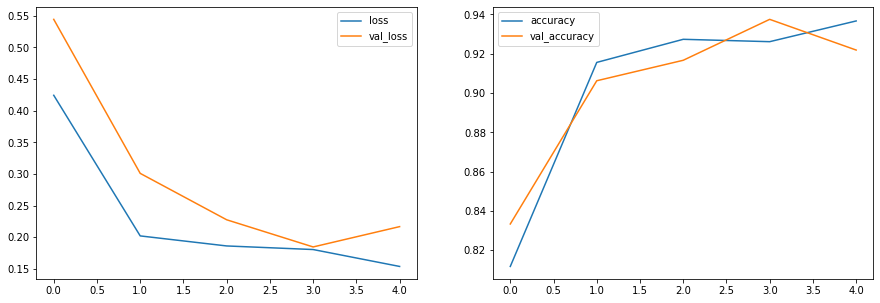

In [19]:
plot_model(history, 'acc')

### Model Evaluation (Accuracy)

In [21]:
loss, accuracy = model.evaluate(test_data, steps=10)
print("Loss: ", loss)
print("Accuracy Score: ",accuracy)

10/10 [==============================] - 156s 17s/step - loss: 0.1786 - acc: 0.9391
Loss:  0.17858552932739258
Accuracy Score:  0.9390624761581421


In [22]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions,axis = 1)
y_test = test_data.classes
class_labels = list(test_data.class_indices.keys())   

### Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

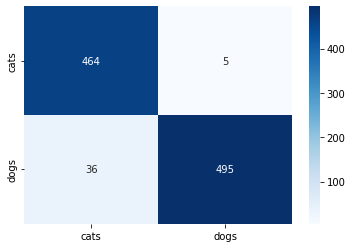

In [23]:
cm = confusion_matrix(y_pred,test_data.classes)
sns.heatmap(cm,
            annot = True,
            fmt = 'd',
            xticklabels=class_labels, 
            yticklabels= class_labels,
            cmap = plt.cm.Blues)
plt.show()

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [24]:
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

        cats       0.99      0.93      0.96       500
        dogs       0.93      0.99      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



#### Creator: Nikhil Shrotri , Github: [Profile](https://github.com/nikhilshrotri)